# *All necessary library imports* 

In [1]:
import os
from pathlib import Path

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image
import plotly.express as px


 # *Path stored with each sub-folder mapped using a dictionary*

In [2]:
DATASET_ROOT = "/kaggle/input/plantvillage-dataset"

DATA_VARIANTS = {
    "color": "color",
    "grayscale": "grayscale",
    "segmented": "segmented",
}


# *Creates data-frame (tabular representation of folder contents) by segmenting images as per their path definitions and associating them with the last two locations defined in the path*

In [3]:
def build_image_dataframe(dataset_dir):
    paths = [
        path.parts[-2:]          # (class_name, image_name)
        for path in Path(dataset_dir).rglob("*.*")
    ]
    df = pd.DataFrame(paths, columns=["Class", "Image"])
    return df.sort_values("Class").reset_index(drop=True)


In [4]:
def get_image_size(image_path):
    img = Image.open(image_path)
    width, height = img.size
    return height, width


# *Creates data-frames for the 3 subfolders within the parent directory (color, grayscale and & prints outputs to verify class imbalance, image count, etc*

In [5]:
eda_results = {}

for name, folder in DATA_VARIANTS.items():
    print(f"\n{'='*10} {name.upper()} DATASET {'='*10}")
    
    dataset_path = os.path.join(DATASET_ROOT, folder)
    df = build_image_dataframe(dataset_path)
    
    print("Total Images:", len(df))
    print("Total Classes:", df["Class"].nunique())
    print("\nImages per class:")
    print(df["Class"].value_counts().head())
    
    # Store results
    eda_results[name] = {
        "df": df,
        "num_images": len(df),
        "num_classes": df["Class"].nunique(),
        "class_distribution": df["Class"].value_counts()
    }



========== COLOR DATASET ==========
Total Images: 54305
Total Classes: 38

Images per class:
Class
Orange___Haunglongbing_(Citrus_greening)    5507
Tomato___Tomato_Yellow_Leaf_Curl_Virus      5357
Soybean___healthy                           5090
Peach___Bacterial_spot                      2297
Tomato___Bacterial_spot                     2127
Name: count, dtype: int64

========== GRAYSCALE DATASET ==========
Total Images: 54305
Total Classes: 38

Images per class:
Class
Orange___Haunglongbing_(Citrus_greening)    5507
Tomato___Tomato_Yellow_Leaf_Curl_Virus      5357
Soybean___healthy                           5090
Peach___Bacterial_spot                      2297
Tomato___Bacterial_spot                     2127
Name: count, dtype: int64

========== SEGMENTED DATASET ==========
Total Images: 54306
Total Classes: 38

Images per class:
Class
Orange___Haunglongbing_(Citrus_greening)    5507
Tomato___Tomato_Yellow_Leaf_Curl_Virus      5357
Soybean___healthy                           5090
Pea

# *Plots bar graphs to visualize the class imbalance*

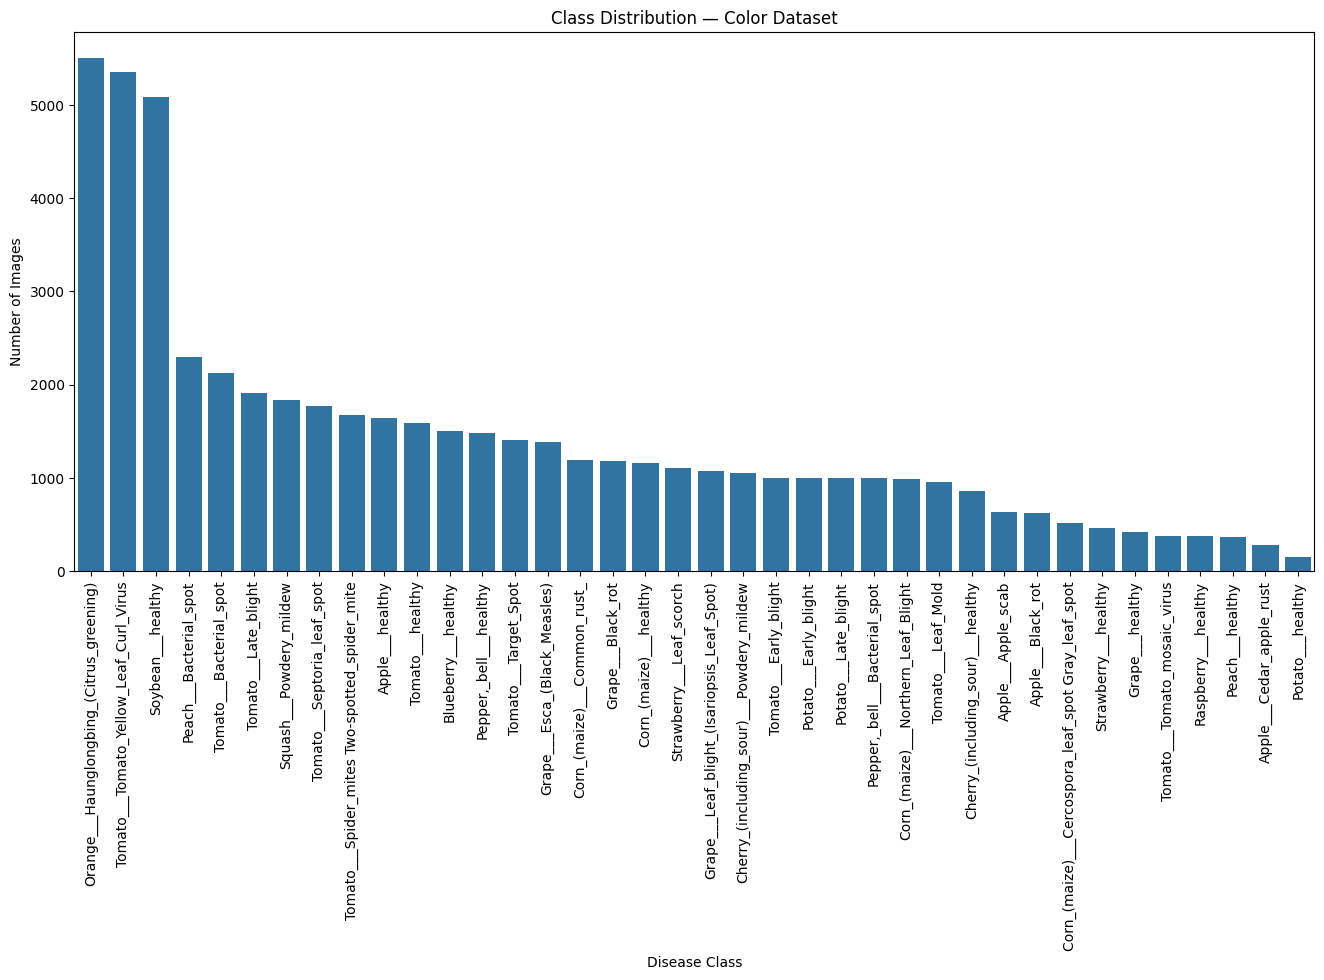

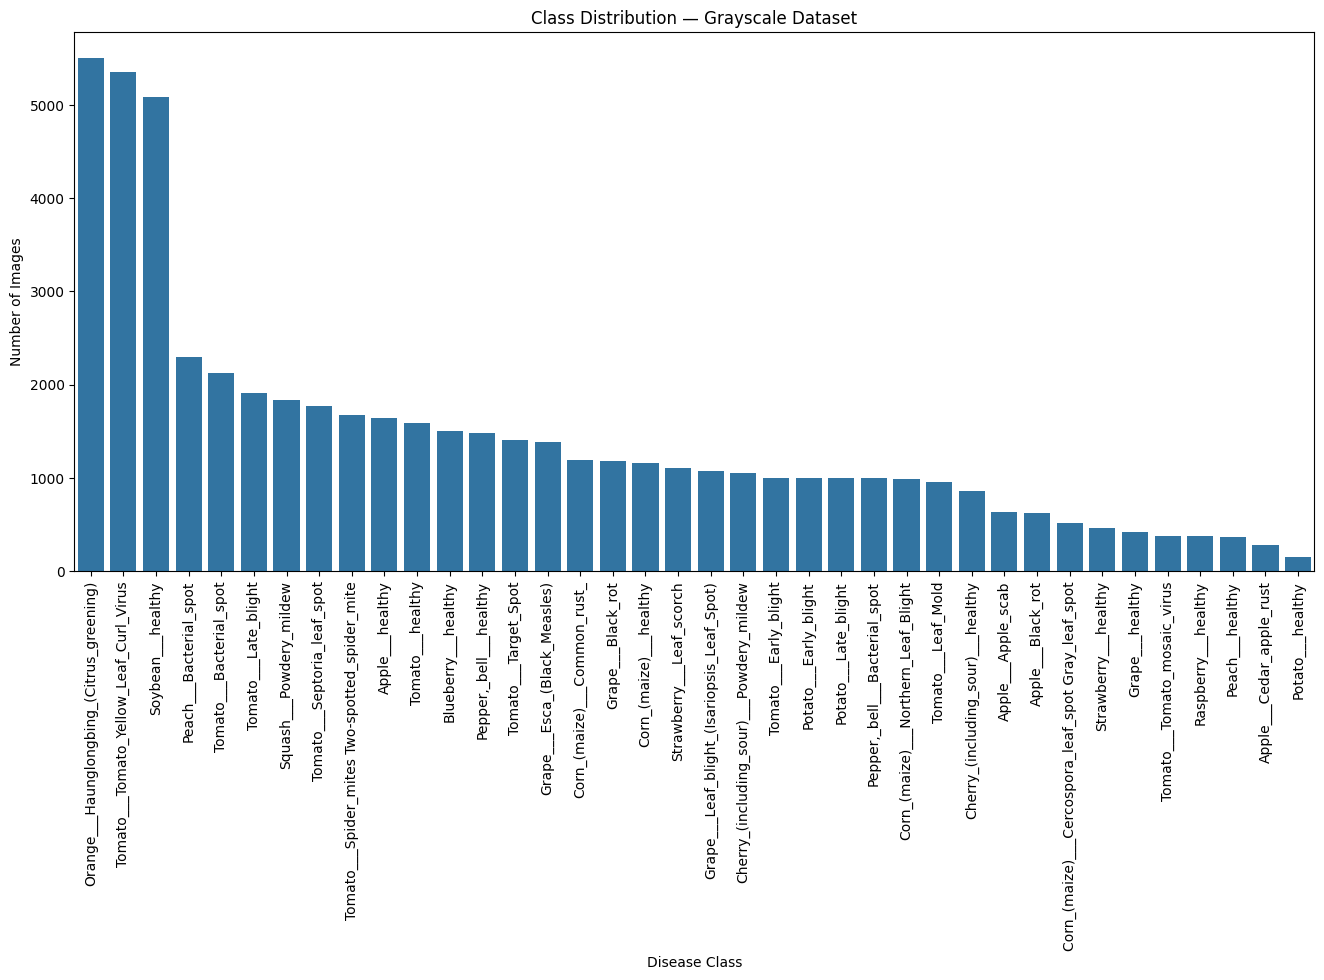

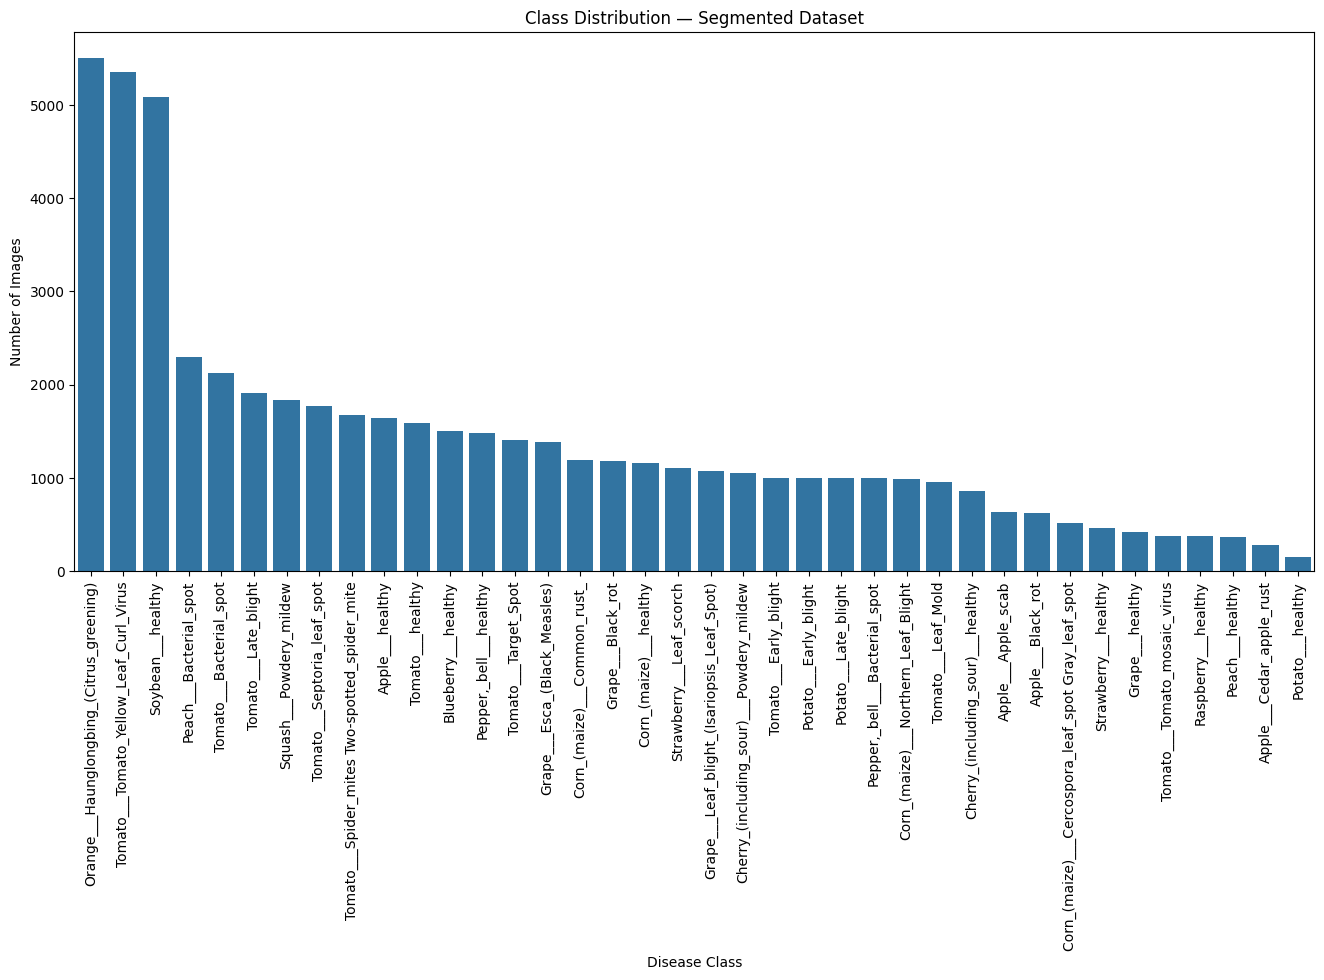

In [6]:
for name, results in eda_results.items():
    df = results["df"]
    
    plt.figure(figsize=(16, 7))
    sns.countplot(
        x=df["Class"],
        order=df["Class"].value_counts().index
    )
    plt.xticks(rotation=90)
    plt.title(f"Class Distribution — {name.capitalize()} Dataset")
    plt.xlabel("Disease Class")
    plt.ylabel("Number of Images")
    plt.show()


# *Generates Pie Chart for the top 10 Classes as per distribution of images*

In [7]:
for name, results in eda_results.items():
    class_counts = results["class_distribution"]

    # keep only top 10 classes
    top_counts = class_counts.head(10)

    fig = px.pie(
        values=top_counts.values,
        names=top_counts.index,
        hole=0.5,
        title=f"Top-10 Class Proportion — {name.capitalize()} Dataset"
    )
    fig.update_traces(textinfo="percent")
    fig.show()


# *Following code blocks verify the image size spread across the sub-datasets by plotting it in 2-D, 3-D and finally plotting frequency vs resolution as well*

In [8]:
def analyze_image_sizes(dataset_path, df, dataset_name):
    sizes = []

    for cls in df["Class"].unique():
        class_dir = os.path.join(dataset_path, cls)

        if not os.path.isdir(class_dir):
            continue   # skip invalid paths safely

        for img in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img)
            try:
                h, w = get_image_size(img_path)
                sizes.append([h, w])
            except:
                continue

    size_df = pd.DataFrame(sizes, columns=["Height", "Width"])

    if len(size_df) == 0:
        print(f"No valid images found for {dataset_name}")
        return size_df

    plt.figure(figsize=(7, 6))
    plt.scatter(size_df["Width"], size_df["Height"], alpha=0.3)
    plt.title(f"Image Resolution Distribution — {dataset_name}")
    plt.xlabel("Width (pixels)")
    plt.ylabel("Height (pixels)")
    plt.show()

    return size_df


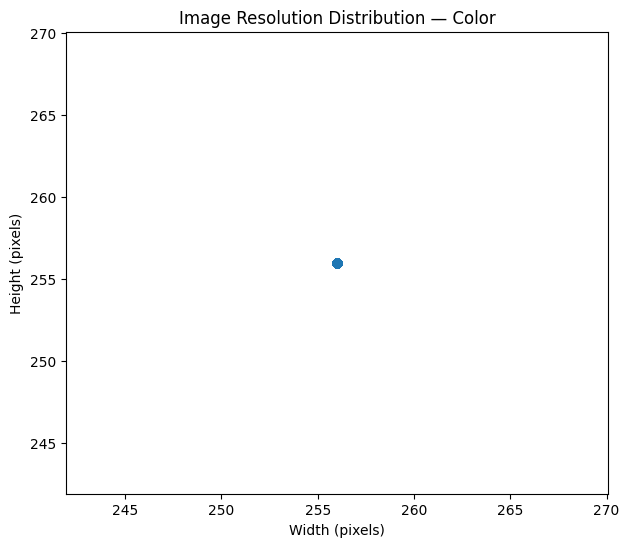

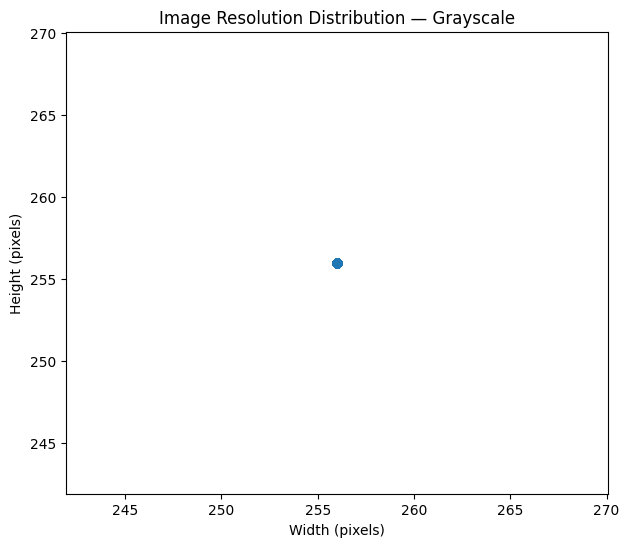

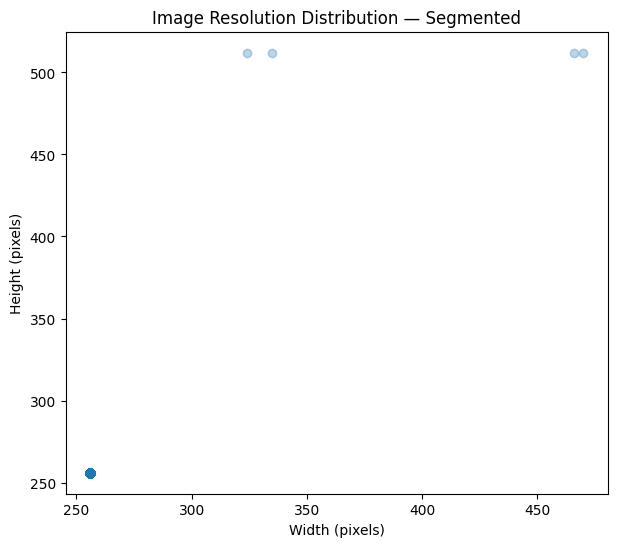

In [9]:
size_distributions = {}

for name, results in eda_results.items():
    dataset_path = os.path.join(DATASET_ROOT, DATA_VARIANTS[name])
    size_df = analyze_image_sizes(dataset_path, results["df"], name.capitalize())
    size_distributions[name] = size_df


In [10]:

for name, size_df in size_distributions.items():

    if size_df.empty:
        print(f"Skipping {name} — no size data")
        continue

    # create stacking axis so identical (H, W) points separate vertically
    plot_df = size_df.copy()
    plot_df["z"] = np.arange(len(plot_df))

    fig = px.scatter_3d(
        plot_df,
        x="Width",
        y="Height",
        z="z",
        opacity=0.05,
        title=f"3D Stacked Image Resolution Verification — {name.capitalize()} Dataset"
    )

    fig.update_traces(marker=dict(size=2))
    fig.update_layout(
        scene=dict(
            xaxis_title="Width (pixels)",
            yaxis_title="Height (pixels)",
            zaxis_title="Image Index (stacking axis)"
        )
    )

    fig.show()


In [11]:
for name, size_df in size_distributions.items():
    if size_df.empty:
        continue

    res_stats = (
        size_df
        .groupby(["Height", "Width"])
        .size()
        .reset_index(name="count")
    )

    res_stats["percentage"] = (
        res_stats["count"] / res_stats["count"].sum() * 100
    ).round(3)

    fig = px.bar(
        res_stats.sort_values("count", ascending=False),
        x="count",
        y=res_stats.apply(lambda r: f"{r.Height}×{r.Width}", axis=1),
        orientation="h",
        text="percentage",
        title=f"Resolution Frequency (%) — {name.capitalize()} Dataset",
    )

    fig.update_layout(
        xaxis_title="Number of Images",
        yaxis_title="Resolution (HxW)",
    )

    fig.show()


# *Heat map visualization as per class imbalance*

In [12]:
for name, results in eda_results.items():
    class_counts = results["class_distribution"].reset_index()
    class_counts.columns = ["Class", "Count"]

    fig = px.imshow(
        class_counts[["Count"]].T,
        x=class_counts["Class"],
        color_continuous_scale="Viridis",
        aspect="auto",
        title=f"Class Imbalance Heatmap — {name.capitalize()} Dataset"
    )

    fig.update_layout(
        xaxis_title="Disease Class",
        yaxis_title="",
        xaxis_tickangle=90
    )

    fig.show()


# *Summarized each image by its mean RGB intensities to assess lighting and color consistency without loading raw pixel distributions. The channel-wise box plots show that the dataset is largely consistent, with minor natural variation expected for plant imagery*

In [13]:
def plot_rgb_summary(dataset_path, df, sample_per_class=50):
    records = []

    for cls in df["Class"].unique():
        class_dir = os.path.join(dataset_path, cls)

        if not os.path.isdir(class_dir):
            continue

        imgs = os.listdir(class_dir)[:sample_per_class]

        for img in imgs:
            img_path = os.path.join(class_dir, img)

            try:
                img = Image.open(img_path).convert("RGB")
                arr = np.array(img)

                records.append({
                    "Class": cls,
                    "R_mean": arr[:,:,0].mean(),
                    "G_mean": arr[:,:,1].mean(),
                    "B_mean": arr[:,:,2].mean()
                })

            except:
                continue

    df_rgb = pd.DataFrame(records)

    fig = px.box(
        df_rgb,
        y=["R_mean", "G_mean", "B_mean"],
        title="RGB Channel Mean Distribution (Per Image)"
    )

    fig.show()
plot_rgb_summary(
    os.path.join(DATASET_ROOT, "color"),
    eda_results["color"]["df"]
)



# *Verifies class-wise resolution consistency by box-plot of image height vs class*

In [14]:
import plotly.express as px

for name, results in eda_results.items():

    size_df = size_distributions[name]

    if size_df.empty:
        print(f"Skipping {name} — no size data")
        continue

    if "Class" not in size_df.columns:
        # Repeat class labels in the same order images were read
        class_labels = []
        df = results["df"]

        for cls in df["Class"].unique():
            class_dir = os.path.join(DATASET_ROOT, DATA_VARIANTS[name], cls)
            if not os.path.isdir(class_dir):
                continue
            n_imgs = len(os.listdir(class_dir))
            class_labels.extend([cls] * n_imgs)

        # Truncate to match size_df length (safety)
        size_df = size_df.copy()
        size_df["Class"] = class_labels[:len(size_df)]

    TOP_N = 38
    top_classes = (
        size_df["Class"]
        .value_counts()
        .head(TOP_N)
        .index
    )

    plot_df = size_df[size_df["Class"].isin(top_classes)]

    fig = px.box(
        plot_df,
        x="Class",
        y="Height",
        points="outliers",
        title=f"Image Height Distribution per Class — {name.capitalize()} Dataset"
    )

    fig.update_layout(
        xaxis_title="Disease Class",
        yaxis_title="Image Height (pixels)",
        xaxis_tickangle=90
    )

    fig.show()
